# Когнитивные технологии

*Алла Тамбовцева*

## Генерирование выборок из различных распределений. Правдоподобие выборки.

### Генерирование выборок из распространённых распределений

Получить выборку заданного объёма из определённого распределения с некоторыми параметрами можно с помощью того же модуля `stats` из библиотеки `scipy`.

In [1]:
import scipy.stats as st

Для этого нужно создать случайную величину с заданным распределением, сохранить её в переменную и применить к ней метод для создания выборки. Для примера создадим выборку из биномиального распределения.  

In [2]:
X = st.binom(n=10, p=0.7)  # случайная величина
X.rvs(8)  # выборка объёма 8

Понятно, что таким образом можно создать выборку из любого дискретного или непрерывного распределения.

In [7]:
# из распределения Пуассона
Y = st.poisson(2)
Y.rvs(10)

array([0, 0, 4, 2, 0, 3, 1, 4, 2, 3])

In [12]:
# из нормального распределения с a=2, sigma=3
st.norm(2, 3).rvs(12)

array([ 3.28938486,  7.19821919, -1.48464074, -0.89904451, -0.24306394,
        8.51202274, -1.65676397,  5.70952848,  7.7097788 ,  0.33977637,
       -0.10745563,  4.93665913])

На всякий случай, вспомним, что для обеспечения воспроизводимости, нужно зафиксировать стартовую точку псевдослучайного алгоритма, который генерирует выборку (*seed*):

In [30]:
from scipy import random as rd

rd.seed(1234)
st.norm(2, 3).rvs(12)

array([ 3.41430549, -1.57292708,  6.29812091,  1.06204431, -0.1617662 ,
        4.66148882,  4.57876524,  0.09042949,  2.04708912, -4.72805486,
        5.45010717,  4.97583807])

In [31]:
rd.seed(1234)
st.norm(2, 3).rvs(12)  # выборка не меняется

array([ 3.41430549, -1.57292708,  6.29812091,  1.06204431, -0.1617662 ,
        4.66148882,  4.57876524,  0.09042949,  2.04708912, -4.72805486,
        5.45010717,  4.97583807])

### Генерирование выборок из произвольных распределений

Теперь рассмотрим более интересную задачу – сгенерируем произвольную дискретную случайную величину на основе массива значений и вероятностей, а затем возьмём из неё выборку. 

In [20]:
import numpy as np
x = np.array([-1, 0, 5, 8])
p = np.array([0.1, 0.4, 0.25, 0.25])

W = st.rv_discrete(name='dist', values=(x, p))  # назовём распределение dist

In [23]:
W.rvs(size=15)  # выборка из 15 наблюдений

array([ 8,  8,  0, -1,  0,  5,  8,  0, -1,  5,  8,  0,  0,  8,  5])

Кстати, ранее это мы не обсуждали, но таким образом можно создать любую случайную величину и определить её характеристики:

In [33]:
W.expect()

3.15

In [37]:
W.stats()

(array(3.15), array(12.4275))

In [39]:
W.pmf(5)  # P(W=5)

0.25

In [41]:
W.cdf(5)  # P(W<=5)

0.75

А теперь сгенерируем непрерывную случайную величину аналогичным образом, только вместо массива вероятностей будет функция плотности вероятности. Пусть 

$$
f(x) = 
\begin{cases}
0.5 x, x \in [0, 2] \\
0, x \notin [0, 2]
\end{cases}.
$$

Создадим класс `my_cont_dist`, который будет описывать случайную величину с непрерывным распределением и задавать её функцию распределения:

In [50]:
class my_cont_dist(st.rv_continuous):
    def _pdf(self, x):
        return 0.5 * x

CV = my_cont_dist(a=0, b=2, name='cont_dist')

In [51]:
CV.expect()  # математическое ожидание 

1.3333333333333335

Построим график функции плотности на отрезке $x \in [0, 2]$:

In [52]:
x = np.linspace(0, 2)
fx = CV.pdf(x)

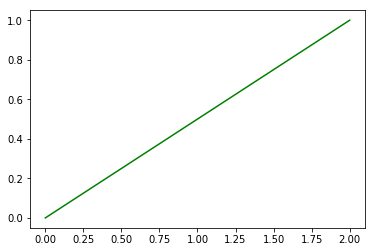

In [53]:
from matplotlib import pyplot as plt
% matplotlib inline

plt.plot(x, fx, 'g')

### Правдоподобие выборок

Правдоподобие выборки $x_1, x_2, \ldots, x_n$, взятой из дискретного распределения, определяется так:

$$
L(x_1, x_2, \ldots, x_n) = \prod\limits_{i=1}^{n}p_i
$$

Правдоподобие выборки $x_1, x_2, \ldots, x_n$, взятой из непрерывного распределения, определяется так:

$$
L(x_1, x_2, \ldots, x_n) = \prod\limits_{i=1}^{n}f(x_i), \text{где $f$ – функция распределения.}
$$

Когда Python генерирует псевдослучайные выборки из распределений, в результате получаются выборки с высоким правдоподобием. Убедимся в этом. Для начала напишем функцию, которая будет вычислять правдоподобие выборки из какого-нибудь распределения. Для примера возьмём биномиальное распределение.

In [74]:
def binom_likelihood(n, p, sample):
    X = st.binom(n, p)
    L = 1
    for x in sample:
        P = X.pmf(x)
        L *= P
    return L

Функция выше перемножает все вероятности значений в поданной на вход выборке и возвращает значение правдоподобия. Из-за того, что перемножаться всё время будут значения меньше $1$, результаты будут очень малы и сравнивать значения правдоподобия будет неудобно. Поэтому давайте поправим функцию так, чтобы она заодно возвращала натуральный логарифм правдоподобия.

In [83]:
def binom_likelihood(n, p, sample):
    X = st.binom(n, p)
    L = 1
    for x in sample:
        P = X.pmf(x)
        L *= P
    return L, np.log(L)

In [84]:
sample1 = st.binom(10, 0.5).rvs(5)
binom_likelihood(10, 0.5, sample1)

(0.00024873671122804943, -8.299115605551385)

Кажется, что значение правдоподобия очень мало. Но это относительно. Предложим выборку со значением, которое не может принадлежать случайной величине с биномиальным распределением с $n=10$, например, $12$:

In [85]:
binom_likelihood(10, 0.5, [3, 6, 12, 4, 0])  # L=0 - выборка неправдоподобна совсем

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


(0.0, -inf)

Или выборки с нетипичными (маловероятными) значениями:

In [86]:
binom_likelihood(10, 0.5, [3, 2, 10, 9, 8])

(2.1582735598713085e-09, -19.953957212680532)

In [88]:
binom_likelihood(10, 0.5, [0, 1, 10, 1, 2])

(3.996802888650572e-12, -26.24552635223885)